# Eksperymenty z cechami na nagraniach samochodów

Najpierw opiszę całą procedurę - krok po proku - a potem pokażę kilka spektrogramów z różnymi parametrami...

Pierwsze polecenie inicuję numpy (biblioteka do obliczeń numerycznych) i matplotlib (do rysowania):

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Audio

Tu wczytuję plik audio. Narysowane są obydwa kanały. Wypisuję też cechy pliku.

Parametry pliku audio: Wav(data.shape=(480000, 2), data.dtype=int32, rate=48000, sampwidth=3)


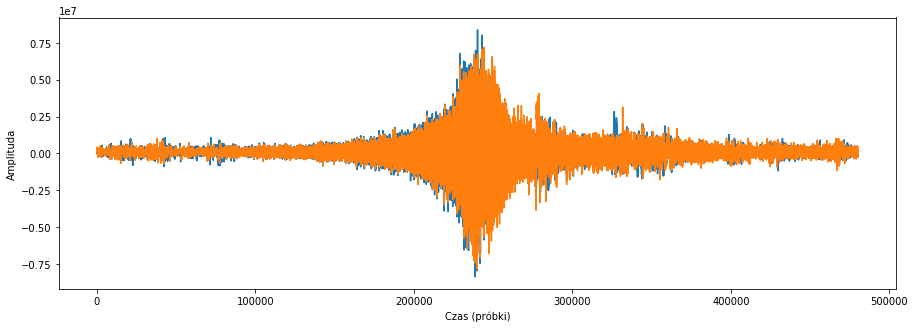

In [2]:
import wavio

audiofile=wavio.read('espace_20170331/1892.wav')
orig_signal=audiofile.data

print 'Parametry pliku audio: {}'.format(audiofile)

figure(figsize=(15,5))
plot(orig_signal)
xlabel(u'Czas (próbki)')
ylabel('Amplituda')

## Stereo $\to$ Mono

Bierzemy tylko lewy kanał.

Nie pamiętam czy tak się umawialiśmy, ale to możemy też przedyskutować...

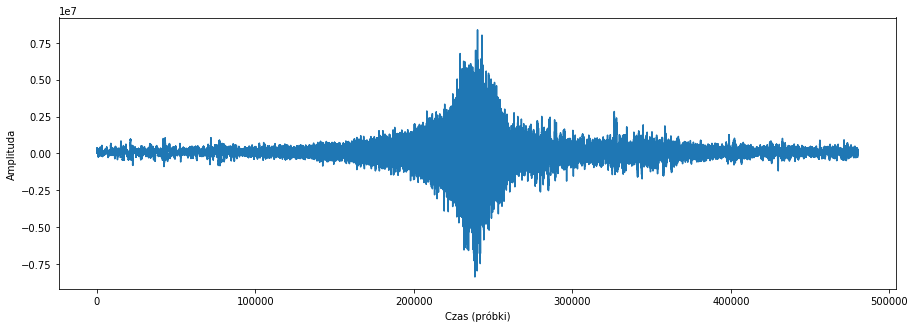

In [3]:
mono_signal=orig_signal[:,0]

figure(figsize=(15,5))
plot(mono_signal)
xlabel(u'Czas (próbki)')
ylabel('Amplituda')

## Resampling

Zmiana próbkowania na 1kHz używając
http://scipy.github.io/devdocs/generated/scipy.signal.resample.html

Tu definiuję funkcję:

In [4]:
from scipy.signal import resample
def my_resample(signal, from_fs=48000, to_fs=8000):
    oldlen=signal.size
    newlen=oldlen*to_fs/from_fs
    return resample(signal,newlen,window='hamming')

A tu jej używam

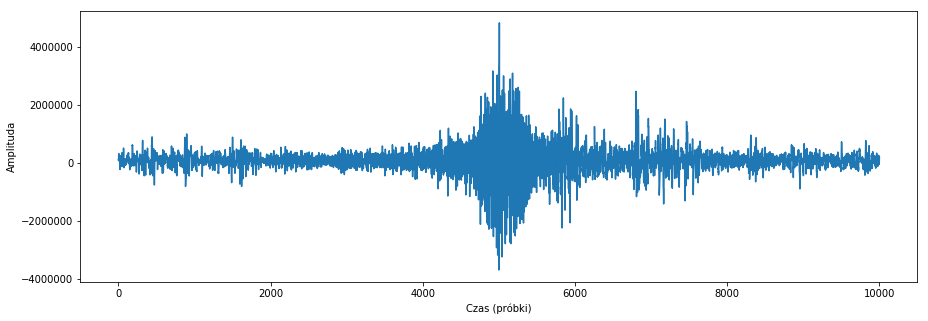

In [5]:
resample_rate=1000

resampled_signal=my_resample(mono_signal,to_fs=resample_rate)

figure(figsize=(15,5))
plot(resampled_signal)
xlabel(u'Czas (próbki)')
ylabel('Amplituda')

## Wycinanie sygnału

Tutaj wycinam fragment sygnału ze środka. Zależy mi na tym żeby mieć określoną ilość sekund, ale ilość okienek zaokrągloną do całości. Przykładowo: jeśli mi zależy na częstotliwości 8 okienek na sekundę i chcę wyciągnąć 3 sekundy, chce żeby na wyjściu było dokładnie 24 okienek. To znaczy, że muszę wyciągnąć trochę więcej sygnału (czyli 3 seknudy z hakiem), bo przez overlap i zaokrąglenia część okienek wypadnie w obliczeniach. Pod spodem podano dokładne przeliczenia.

W eksperymencie zakładam następujące parametry:

In [6]:
len_clip=3.0 #ilość sekund wyciągniętych ze środka sygnału
frame_rate=8 #ilość okienek na sekundę
overlap=3.0/4 #stosunek nakładania się okienek

Wynikają one z osobistej preferencji. Niektórzy mogą chcieć definiować *frame_size* i *hop_size* bezpośrednio, ale dla mnie jest bardziej sensowne żeby zdefniować *overlap* i *frame_rate* bo ma to bardziej bezpośrednie przełożenie na to jak te cechy są stosowane. Inne parametry można wyliczyć bezpośrednio z tych wyżej:

In [7]:
hop_size=int(resample_rate//frame_rate)
frame_size=int(hop_size//(1.0-overlap))
frame_num=int(len_clip*frame_rate)

#funkcja przeliczająca próbki -> ms
to_ms=lambda x: 1000.0*x/resample_rate

print 'Frame size: {} samples {} ms'.format(frame_size,to_ms(frame_size))
print 'Hop size: {} samples {} ms'.format(hop_size,to_ms(hop_size))
print 'Frame num: {}'.format(frame_num)

Frame size: 500 samples 500.0 ms
Hop size: 125 samples 125.0 ms
Frame num: 24


Tak jak wspominałem, bez dodania trochę sygnału ponad *len_clip* sekund, ilość okienek rzeczywiście wyciągniętych z sygnału będzie mniejsz niż *frame_num* wyliczony powyżej. Dlatego wyliczamy i dodajemy wartość *pad* do sygnału (połowę tej wartości do początku, a połowę do końca sygnału):

In [8]:
#standardowy wzór na obliczenie ilości ramek z sygnału o długości 'x' próbek:
to_fn=lambda x: int((x-frame_size)//hop_size)+1

print 'Frame count without pad: {}'.format(to_fn(len_clip*resample_rate))

pad=frame_size-hop_size+1

print 'Padding: {} samples {} ms'.format(pad,to_ms(pad))

print 'Frame count with pad: {}'.format(to_fn(len_clip*resample_rate+pad))

Frame count without pad: 21
Padding: 376 samples 376.0 ms
Frame count with pad: 24


Tutaj łączę wszystko razem:

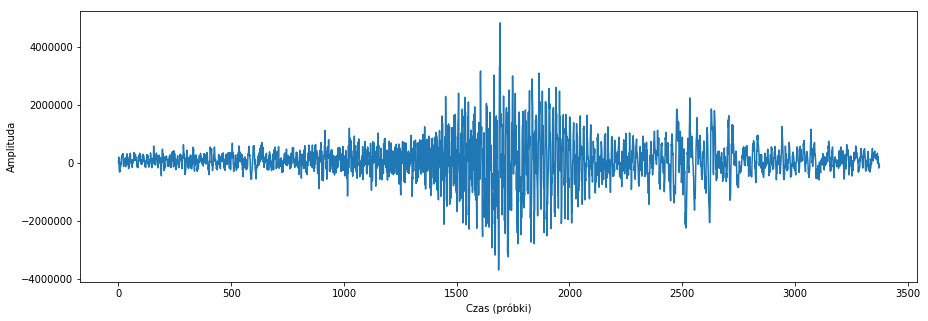

In [9]:
def clip_signal(signal, len_clip=3.0,  frame_rate=8, overlap=3.0/4, samplerate=1000):
    hop_size=int(samplerate//frame_rate)
    frame_size=int(hop_size//(1.0-overlap))
    frame_num=int(len_clip*frame_rate)
    pad=frame_size-hop_size+1
    ln=int((len_clip*samplerate+pad)//2)
    mp=int(signal.size//2) #punkt środkowy sygnału
    return signal[mp-ln:mp+ln]
    
clipped_signal = clip_signal(resampled_signal,3.0,8,3.0/4,resample_rate)
figure(figsize=(15,5))
plot(clipped_signal)
xlabel(u'Czas (próbki)')
ylabel('Amplituda')

## Okienkowanie

Tu zamieniamy wektor 1-D zawierający sygnał na macierz 2-D zawierającą poszczególne okienka:

In [10]:
def signal_to_frames(signal, samplerate=1000, frame_rate=8, overlap=3.0/4):
    sig_len=signal.size
    hop_size=int(samplerate//frame_rate)
    frame_size=int(hop_size//(1.0-overlap))
    frame_num=(sig_len-frame_size)/hop_size+1
    frames=[]
    for fr in range(frame_num):
        start=fr*hop_size
        end=start+frame_size
        frames.append(signal[start:end])
    return np.array(frames)

In [11]:
frames=signal_to_frames(clipped_signal,resample_rate,8,3.0/4)
print 'Frames matrix shape: {}'.format(frames.shape)

Frames matrix shape: (24, 500)


## Preemfaza

Jest to procedura która podbija wyższe częstotliwości i koryguje pewne cechy związane z rejestracją sygnału mikrofonem. Tego w końcu nie użyto w pracy, ale można się nad tym jeszcze zastanowić. Nie użyto ponieważ na wyższych częstotliwościach nie znaleźliśmy pożytecznych informacji (jeszcze).

In [12]:
def preemphasis(frames,coeff=0.9):
    if coeff==0:
        return frames
    out=[]
    for frame in frames:
        frame -= np.hstack((frame[0], frame[:-1])) * coeff
        out.append(frame)
    return np.array(out)

## STFT

Tutaj liczymy STFT sygnału okienkowanych okienkiem hamminga. Zapisujemy tylko moduł (amplitudę) pierwszej połowy widma ($0 \ldots F_s/2$):

In [13]:
def frames_to_stft(frames):
    stft=[]
    win=np.hamming(frames.shape[1])
    for fr in frames:
        H=np.fft.rfft(fr*win)
        stft.append(np.abs(H)[1:])
    return np.array(stft)

Size of output: (24, 250)


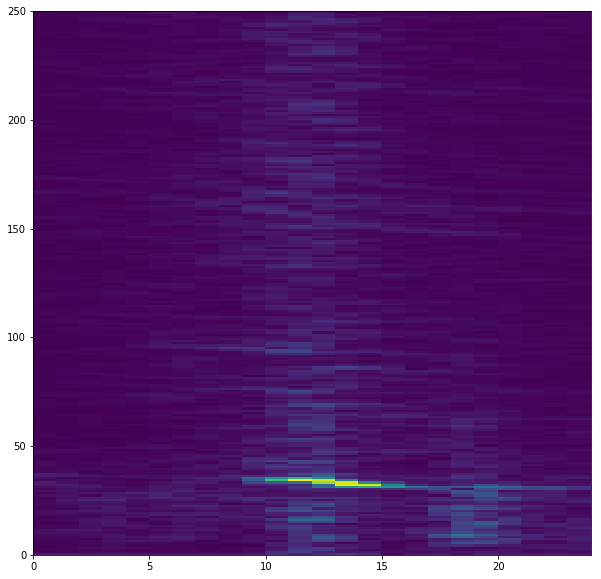

In [14]:
stft=frames_to_stft(frames)

figure(figsize=(10,10))
pcolormesh(stft.T)

print 'Size of output: {}'.format(stft.shape)

## Filtrowanie

Filtrowanie to nic innego jak uśrednianie puntków FFT wyliczonych powyżej. Zamiast 1000 punktów możemy wyliczyć kilkakrotnie mniej. Opróćz tego, możemy je tak ułożyć żeby niższe częstotliwości były lepiej reprezentowane na wykresie niż wyższe. Inaczej mówiąc, zamiast skali liniowiej otrzymamy skalę logarytmiczną reprezentującą częstotliwości. Skala melowa jest motywowana percepcyjnie (przez ludzi), ale do tego zastosowania to nie ma większego znaczenia - używamy jej bo jest wygodna (możemy podyskutować czy nie warto stosować czegoś innego).

Tu tworzymy macierz trójkątnych filtrów uśredniających:

In [15]:
def create_filter(filter_num, rfft_len, samp_freq, lo_freq, hi_freq):
    mel2freq = lambda mel: 700.0 * (np.exp(mel / 1127.0) - 1)
    freq2mel = lambda freq: 1127 * (np.log(1 + (freq / 700.0)))
    
    filter_mat = np.zeros((rfft_len, filter_num))

    lo_mel = freq2mel(lo_freq);
    hi_mel = freq2mel(hi_freq);

    mel_c = np.linspace(lo_mel, hi_mel, filter_num + 2)
    freq_c = mel2freq(mel_c);
    point_c = freq_c / float(samp_freq/2) * rfft_len
    point_c = np.floor(point_c).astype('int')
    
    if point_c[-1]==rfft_len:
        point_c[-1]-=1
    
    for f in range(filter_num):
        d1 = point_c[f + 1] - point_c[f]
        d2 = point_c[f + 2] - point_c[f + 1]
        
        filter_mat[point_c[f]:point_c[f + 1] + 1, f] = np.linspace(0, 1, d1 + 1)
        filter_mat[point_c[f + 1]:point_c[f + 2] + 1, f] = np.linspace(1, 0, d2 + 1)
        
    return filter_mat

Tak one wyglądają:

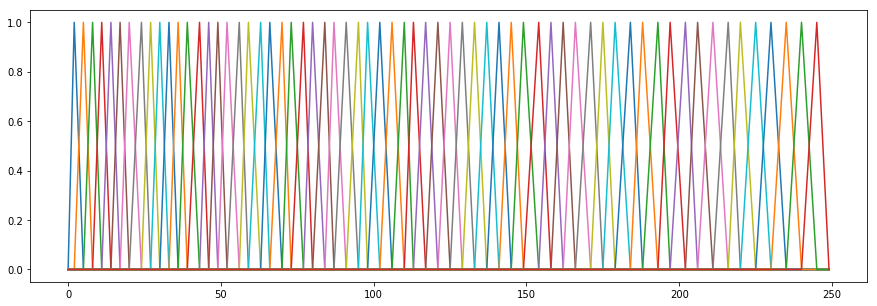

In [16]:
filter_mat=create_filter(64,stft.shape[1],resample_rate,0,resample_rate/2)
figure(figsize=(15,5))
_=plot(filter_mat)

## Stosowanie filtrów

Procedura uśredniania filtrów jest wykonywana wykorzystując iloczyn skalarny.

Melbank shape: (24, 64)


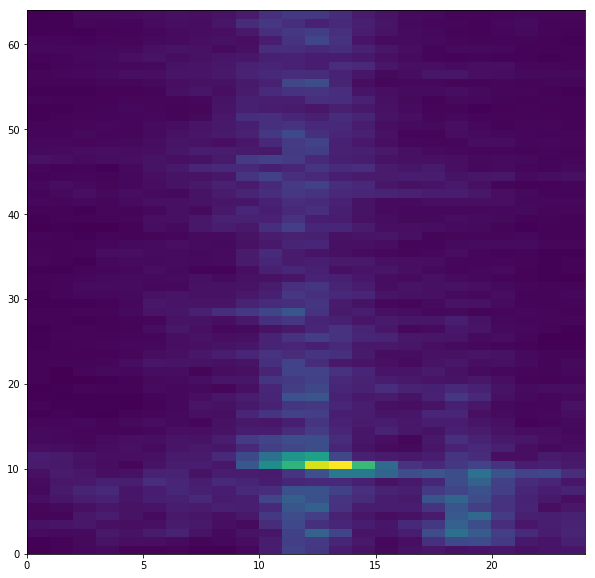

In [17]:
def apply_filter(stft, filter_mat):
    melbank=[]
    for fr in stft:
        mel=np.dot(fr,filter_mat)
        melbank.append(mel)
    return np.array(melbank)


melbank=apply_filter(stft, filter_mat)

figure(figsize=(10,10))
pcolormesh(melbank.T)

print 'Melbank shape: {}'.format(melbank.shape)

## Normalizacja

Na powyższym wykresie widać że niektóre ramki są bardziej wyraźne od innych. Ponieważ samochód przejeżdża obok mikrofonu, najgłośniejszy jest w momencie przejazdu. Łatwym rozwiązaniem jest podzielenie każdej ramki przez energię. Energię można policzyć po prostu jako sumę wszystkich pasm częstotliwości w danej ramce. Można też na to patrzeć jako normalizację częstotliwości do normy $L^1$. Innym podobnym efektem jest Dynamic Range Compression, chociaż tutaj jest liczone na poziomie ramek (DRC jest algorytm działający na próbkach sygału).

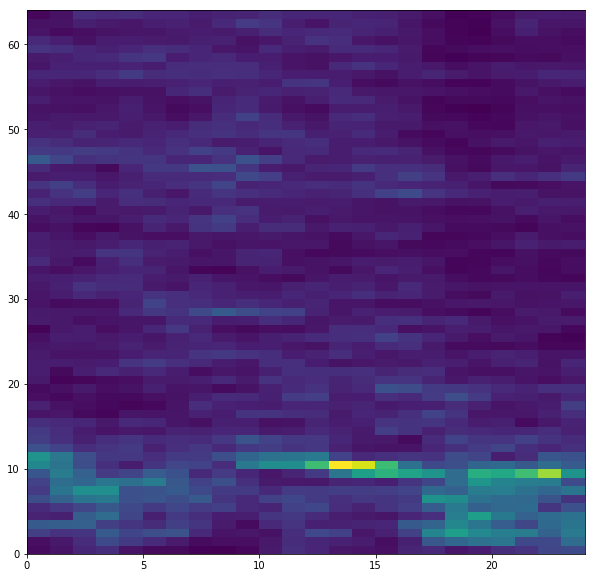

In [18]:
def frame_normalize(melbank):
    melbank_norm=[]
    for fr in range(melbank.shape[0]):
        melbank_norm.append(melbank[fr]/melbank[fr].sum())
    return np.array(melbank_norm)
    
melbank_norm=frame_normalize(melbank)
    
figure(figsize=(10,10))
pcolormesh(melbank_norm.T)

## Logarytm

Logarytm widma zwiększa szczegóły obrazu. Ułatwia wyszukiwanie cech. Jest też uzasadnione zarówno matematycznie jak i percepcyjnie:

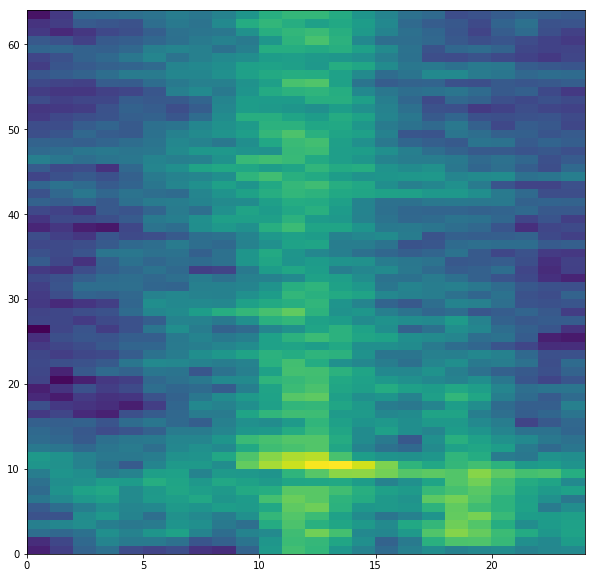

In [19]:
melbank_log=log(melbank)

figure(figsize=(10,10))
pcolormesh(melbank_log.T)

# Wszystko razem

Łączymy powyższe w jedną metodę:

In [20]:
import wavio

def process(audio_file, mono='L', samplerate=1000, clip_len=3.0, frame_rate=8, overlap=0.75, 
            preemph_coeff=0, filt_num=64, lo_freq=0, hi_freq=None, apply_norm=True, apply_log=True):
    
    audiofile=wavio.read(audio_file)

    signal=audiofile.data

    if mono=='L':
        signal=signal[:,0]
    elif mono=='R':
        signal=signal[:,1]
    elif mono=='Avg':
        signal=np.mean(signal,axis=1)
    else:
        raise ValueError('Mono needs to be either L, R or Avg')
    
    signal=my_resample(signal,from_fs=audiofile.rate, to_fs=samplerate)
    
    signal = clip_signal(signal,clip_len,frame_rate,overlap,samplerate)
    
    ret=signal_to_frames(signal,samplerate,frame_rate,overlap)
    
    if preemph_coeff>0:
        ret=preemphasis(ret,preemph_coeff)
    
    ret=frames_to_stft(ret)
    
    if not hi_freq:
        hi_freq=samplerate/2
    
    filter_mat=create_filter(filt_num,ret.shape[1],samplerate,lo_freq,hi_freq)

    ret=apply_filter(ret, filter_mat)

    if apply_norm:
        ret=frame_normalize(ret)

    if apply_log:
        ret=log(ret)
            
    return ret

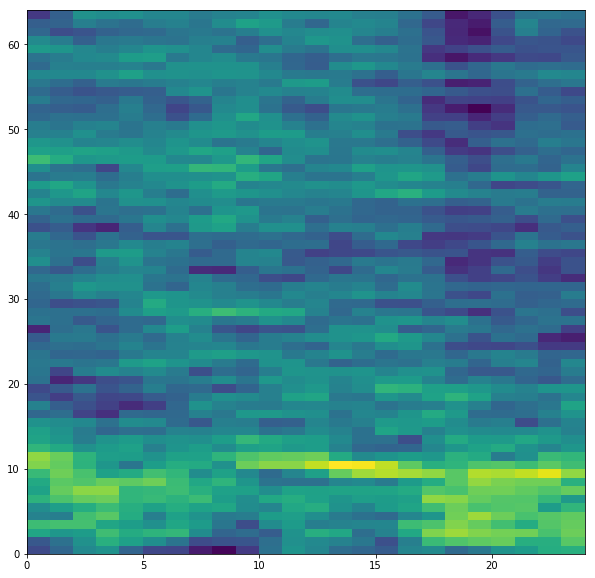

In [21]:
data=process('espace_20170331/1892.wav')

figure(figsize=(10,10))
pcolormesh(data.T)

# Eksperymenty

In [22]:
audio_path='espace_20170331/1892.wav'

## Porównanie metod stereo $\to$ mono

Nie widać specjalnie różnicy, ale uśrednianie może powodować rozmazanie wykresu w ekstremalnych warunkach...

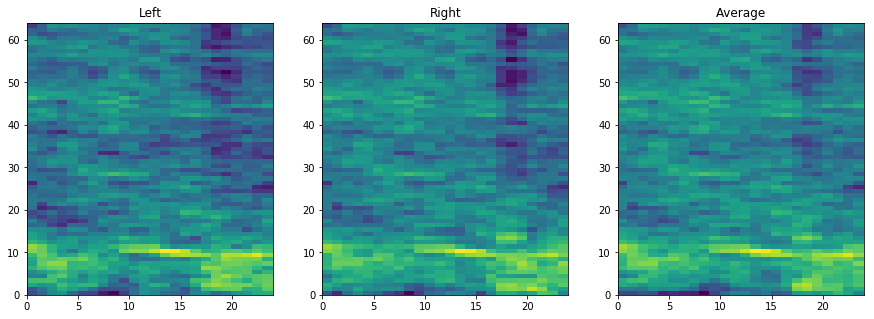

In [23]:
dataL=process(audio_path,mono='L')
dataR=process(audio_path,mono='R')
dataAvg=process(audio_path,mono='Avg')

f,ax=subplots(1,3,figsize=(15,5))
ax[0].pcolormesh(dataL.T)
ax[0].set_title('Left')
ax[1].pcolormesh(dataR.T)
ax[1].set_title('Right')
ax[2].pcolormesh(dataAvg.T)
ax[2].set_title('Average')

## Resampling

Resampling nic nie zmienia, jeśli analizujemy ten sam zakres częstotliwości

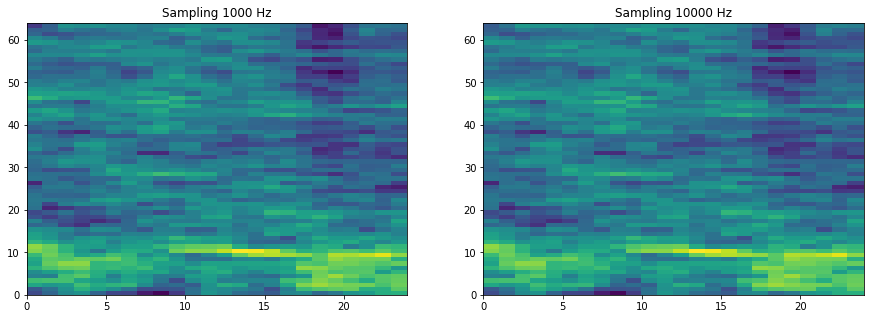

In [24]:
data1k=process(audio_path,samplerate=1000,lo_freq=0,hi_freq=500)
data10k=process(audio_path,samplerate=10000,lo_freq=0,hi_freq=500)

f,ax=subplots(1,2,figsize=(15,5))
ax[0].pcolormesh(data1k.T)
ax[0].set_title('Sampling 1000 Hz')
ax[1].pcolormesh(data10k.T)
ax[1].set_title('Sampling 10000 Hz')

Jeśli mamy różne zakesy częstotliwości, otrzymujemy różny obraz. Pytanie jest co nas interesuje najbardziej - gdzie jest najwięcej informacji:

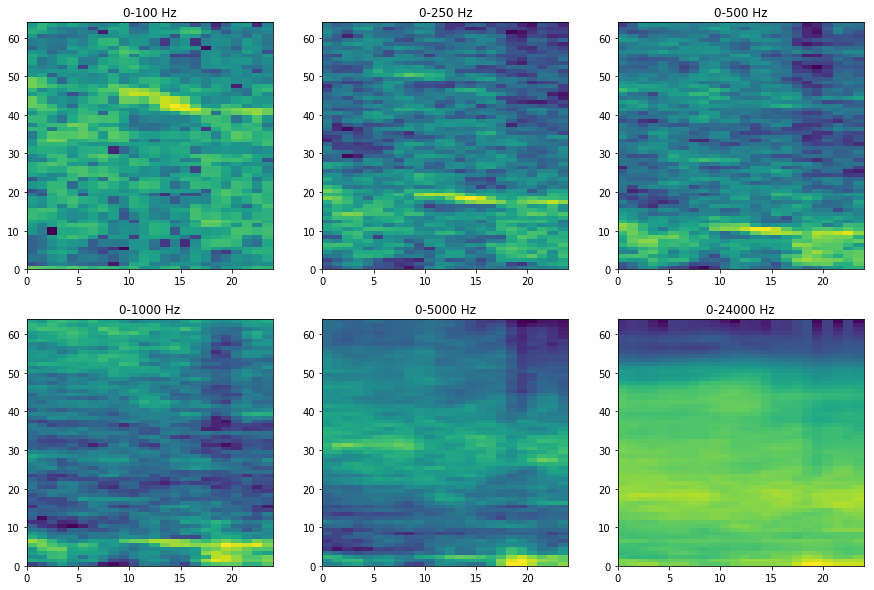

In [25]:
data200=process(audio_path,samplerate=200)
data500=process(audio_path,samplerate=500)
data1k=process(audio_path,samplerate=1000)
data2k=process(audio_path,samplerate=2000)
data10k=process(audio_path,samplerate=10000)
datafull=process(audio_path,samplerate=48000)

f,ax=subplots(2,3,figsize=(15,10))
ax[0,0].pcolormesh(data200.T)
ax[0,0].set_title('0-100 Hz')
ax[0,1].pcolormesh(data500.T)
ax[0,1].set_title('0-250 Hz')
ax[0,2].pcolormesh(data1k.T)
ax[0,2].set_title('0-500 Hz')
ax[1,0].pcolormesh(data2k.T)
ax[1,0].set_title('0-1000 Hz')
ax[1,1].pcolormesh(data10k.T)
ax[1,1].set_title('0-5000 Hz')
ax[1,2].pcolormesh(datafull.T)
ax[1,2].set_title('0-24000 Hz')

## Wycinanie sygnału

Możemy analizować różne fragemnty sygnału - to jest raczej oczywiste co powoduje:

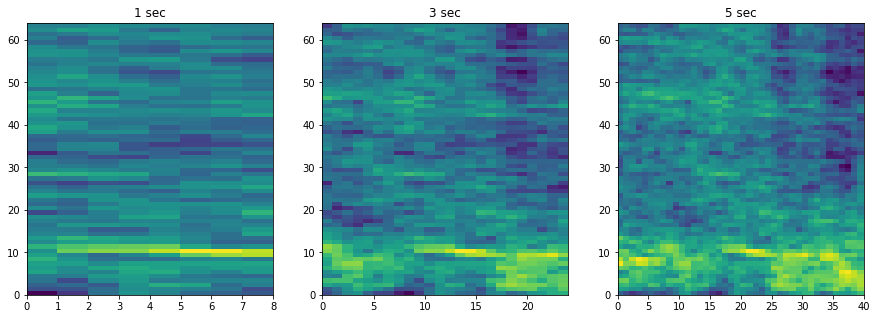

In [26]:
data1=process(audio_path,clip_len=1)
data3=process(audio_path,clip_len=3)
data5=process(audio_path,clip_len=5)

f,ax=subplots(1,3,figsize=(15,5))
ax[0].pcolormesh(data1.T)
ax[0].set_title('1 sec')
ax[1].pcolormesh(data3.T)
ax[1].set_title('3 sec')
ax[2].pcolormesh(data5.T)
ax[2].set_title('5 sec')

## Okienkowanie

Możemy zmieniać ilość okienek na sekundę - zwiększy to rzodzielczość w czasie kosztem rozdzielczości w czestotliwości:

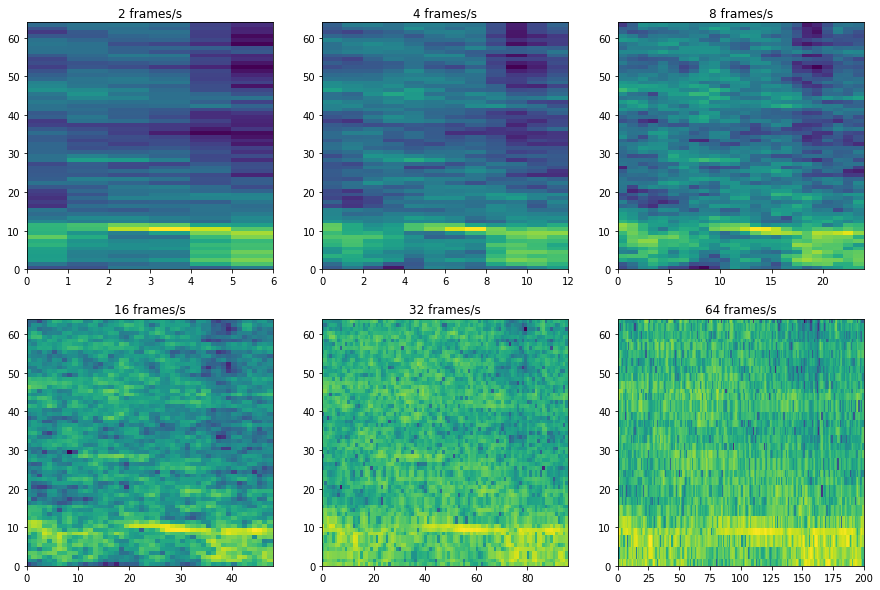

In [27]:
data2=process(audio_path,frame_rate=2)
data4=process(audio_path,frame_rate=4)
data8=process(audio_path,frame_rate=8)
data16=process(audio_path,frame_rate=16)
data32=process(audio_path,frame_rate=32)
data64=process(audio_path,frame_rate=64)

f,ax=subplots(2,3,figsize=(15,10))
ax[0,0].pcolormesh(data2.T)
ax[0,0].set_title('2 frames/s')
ax[0,1].pcolormesh(data4.T)
ax[0,1].set_title('4 frames/s')
ax[0,2].pcolormesh(data8.T)
ax[0,2].set_title('8 frames/s')
ax[1,0].pcolormesh(data16.T)
ax[1,0].set_title('16 frames/s')
ax[1,1].pcolormesh(data32.T)
ax[1,1].set_title('32 frames/s')
ax[1,2].pcolormesh(data64.T)
ax[1,2].set_title('64 frames/s')

Można też zmieniać overlap, ale to niewiele zmienia. Według literatury, do okienka Hamminga pasuje overlap $3/4$: 

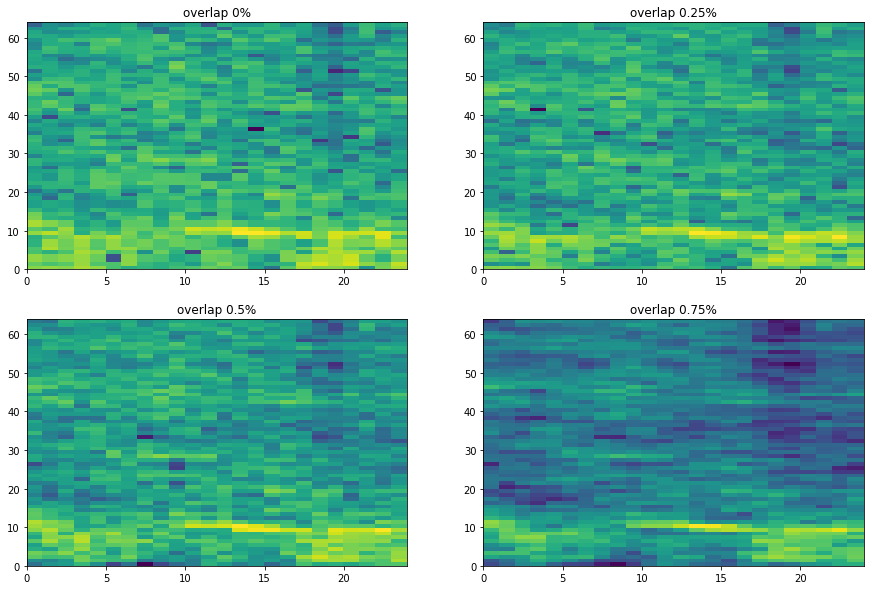

In [28]:
data0=process(audio_path,overlap=0)
data1_4=process(audio_path,overlap=0.25)
data1_2=process(audio_path,overlap=0.5)
data3_4=process(audio_path,overlap=0.75)

f,ax=subplots(2,2,figsize=(15,10))
ax[0,0].pcolormesh(data0.T)
ax[0,0].set_title('overlap 0%')
ax[0,1].pcolormesh(data1_4.T)
ax[0,1].set_title('overlap 0.25%')
ax[1,0].pcolormesh(data1_2.T)
ax[1,0].set_title('overlap 0.5%')
ax[1,1].pcolormesh(data3_4.T)
ax[1,1].set_title('overlap 0.75%')

## Preemfaza

Stosowanie preemfazy zwiększa widoczność wyższych częstotliwości:

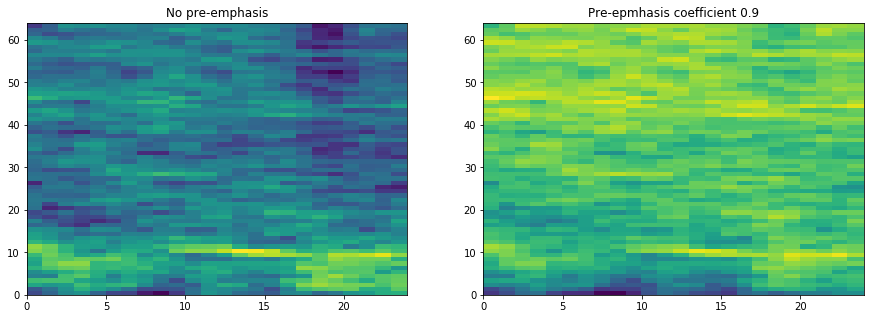

In [29]:
data=process(audio_path)
data_pe=process(audio_path,preemph_coeff=0.9)

f,ax=subplots(1,2,figsize=(15,5))
ax[0].pcolormesh(data.T)
ax[0].set_title('No pre-emphasis')
ax[1].pcolormesh(data_pe.T)
ax[1].set_title('Pre-epmhasis coefficient 0.9')

## Filtrowanie

Filtry redukują ilość parametrów do analizy przez wygładzanie (uśrednianie) sąsiędnich wartości:

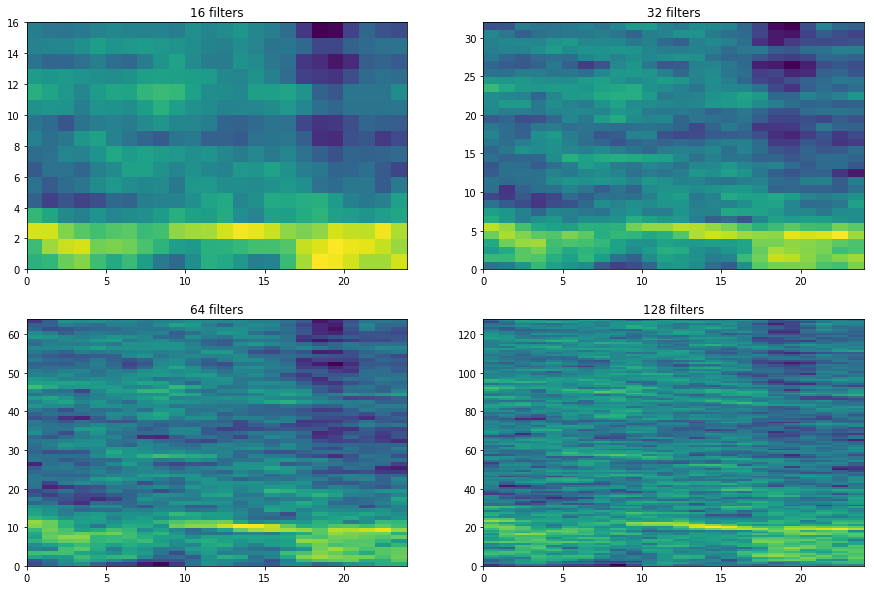

In [30]:
data16=process(audio_path,filt_num=16)
data32=process(audio_path,filt_num=32)
data64=process(audio_path,filt_num=64)
data128=process(audio_path,filt_num=128)

f,ax=subplots(2,2,figsize=(15,10))
ax[0,0].pcolormesh(data16.T)
ax[0,0].set_title('16 filters')
ax[0,1].pcolormesh(data32.T)
ax[0,1].set_title('32 filters')
ax[1,0].pcolormesh(data64.T)
ax[1,0].set_title('64 filters')
ax[1,1].pcolormesh(data128.T)
ax[1,1].set_title('128 filters')

## Normalizacja i logarytm

Logarytm podbija wszystkie szczegóły w obrazie, a normalizacja wyrównuje obraz w czasie (podbija cichę fragmenty po lewej i prawej stronie obrazu):

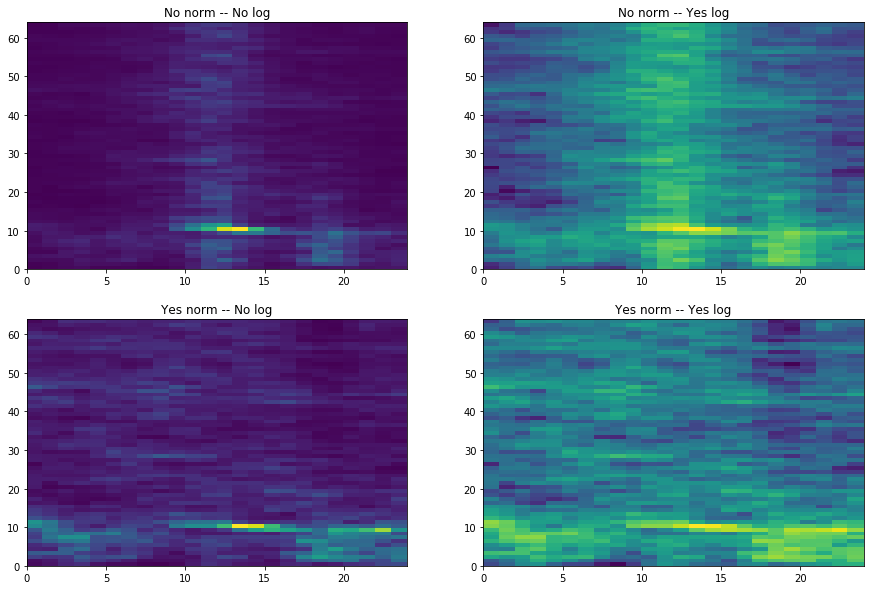

In [31]:
data00=process(audio_path,apply_norm=False,apply_log=False)
data01=process(audio_path,apply_norm=False,apply_log=True)
data10=process(audio_path,apply_norm=True,apply_log=False)
data11=process(audio_path,apply_norm=True,apply_log=True)

f,ax=subplots(2,2,figsize=(15,10))
ax[0,0].pcolormesh(data00.T)
ax[0,0].set_title('No norm -- No log')
ax[0,1].pcolormesh(data01.T)
ax[0,1].set_title('No norm -- Yes log')
ax[1,0].pcolormesh(data10.T)
ax[1,0].set_title('Yes norm -- No log')
ax[1,1].pcolormesh(data11.T)
ax[1,1].set_title('Yes norm -- Yes log')